In [1]:
!head -n4 data/experimental/Pho4_library1_MITOMI_ddGs.csv

,name,sequence,no_adapters,Pho4_PSAM_predicted_Kd,Pho4_Kd_181114,Pho4_Kd_181206,Pho4_Kd_181217,Pho4_ddG_181114,Pho4_ddG_181206,Pho4_ddG_181217,Pho4_PSAM_predicted_ddG,Pho4_ddG_mean,Pho4_ddG_stdev
0,Motif_and_repeat_strong_5,CGCTGTGTGTGTGTGTGTCACGTGACACACACCACAAACGTCCGGCGGTATGAC,TGTGTGTGTGTGTGTCACGTGACACACACCACAAAC,718.8407448178726,749.442637075116,343.793574062843,279.924645516979,-1.5155194471629732,-1.843027634514646,-2.827565984005944,-5.768220492884841,-2.0620376885611877,0.5575784438328
1,Motif_and_repeat_strong_6,CGCATATATATATAGAGTCACGTGACTCTCGCGCGCGCGGTCCGGCGGTATGAC,ATATATATATAGAGTCACGTGACTCTCGCGCGCGCG,818.330448674108,875.2323503252969,167.458267688876,218.29063765203202,-1.4245609924474694,-2.264703559878294,-2.9733560936177335,-5.69223025512614,-2.220873548647832,0.6330520614534
2,Motif_and_repeat_strong_10,CGCTGTGTGTGTGTGTGTCACGTGACACACAACACACACGTCCGGCGGTATGAC,TGTGTGTGTGTGTGTCACGTGACACACAACACACAC,118.898776516689,839.869560567991,431.016493936064,283.738052783534,-1.4487385

In [2]:
!head -n4 data/experimental/Pho4_library2_MITOMI_ddGs.csv

,name,sequence,no_adapters,Pho4_PSAM_predicted_Kd,Pho4_191031_d1_Kd,Pho4_191031_d3_Kd,Pho4_191104_Kd,Pho4_ddG_191031_d1,Pho4_ddG_191031_d3,Pho4_ddG_191104,Pho4_PSAM_predicted_ddG,Pho4_ddG_mean,Pho4_ddG_stdev,good_extension
0,Rand_long1,CGCCCCAGCACTGCCAAGCCGACGTTAAAACGGGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTTGAGTGCATCGAATAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,CCCAGCACTGCCAAGCCGACGTTAAAACGGGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTTGAGTGCATCGAATAGTTCGGTTTATGAG,674.2842042454671,7329.4895885814,8009.004157429259,4979.1809741977395,0.0,-0.023220138597436768,-0.2552006421128979,-0.12134260186217023,-0.09280692690344489,0.11522031870513041,True
1,GT_AC_45bp,CGCCCCAGCACTGCCAAGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTCACGTGACACACACACACACACACACACACACACACACACACACACACACACAAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,CCCAGCACTGCCAAGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTCACGTGACACACACACACACACACACACACACACACACACACACACACACACAAGTTCGGTTTATGAG,815.0

In [3]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/pho4_pbexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [5]:
lib1_flank_seqs = []
lib1_tasks = []
tasks_cols = [12]#[8,9,10,11,12]
lib1_task_names = []
for col in tasks_cols:
    lib1_tasks.append([])
firstLine = True
skipped = 0
with open("data/experimental/Pho4_library1_MITOMI_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            print(line.strip().split(',')[2])
            for col in tasks_cols:
                lib1_task_names.append(line.strip().split(',')[col])
                print(line.strip().split(',')[col])
            continue
        if any(ambig in line.strip().split(',')[2] for ambig in ['S', 'W', 'K', 'M', 'R', 'Y']):
            skipped += 1
            continue
        lib1_flank_seqs.append(line.strip().split(',')[2])
        for idx, col in enumerate(tasks_cols):
            lib1_tasks[idx].append(float(line.strip().split(',')[col]))
print("skipped "+str(skipped)+" ambiguous seqs")

sequence
Pho4_ddG_mean
skipped 0 ambiguous seqs


In [6]:
lib2_good_flank_seqs = []
lib2_bad_flank_seqs = []
lib2_good_tasks = []
lib2_bad_tasks = []
lib2_task_names = []
for col in tasks_cols:
    lib2_good_tasks.append([])
for col in tasks_cols:
    lib2_bad_tasks.append([])
firstLine = True
skipped = 0
with open("data/experimental/Pho4_library2_MITOMI_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            print(line.strip().split(',')[2])
            for col in tasks_cols:
                lib2_task_names.append(line.strip().split(',')[col])
                print(line.strip().split(',')[col])
            continue
        if any(ambig in line.strip().split(',')[2] for ambig in ['S', 'W', 'K', 'M', 'R', 'Y']):
            skipped += 1
            continue
        if line.strip().split(',')[-1] == "True":
            lib2_good_flank_seqs.append(line.strip().split(',')[2])
            for idx, col in enumerate(tasks_cols):
                lib2_good_tasks[idx].append(float(line.strip().split(',')[col]))
        else:
            lib2_bad_flank_seqs.append(line.strip().split(',')[2])
            for idx, col in enumerate(tasks_cols):
                lib2_bad_tasks[idx].append(float(line.strip().split(',')[col]))
print("skipped "+str(skipped)+" ambiguous seqs")

sequence
Pho4_ddG_mean
skipped 3 ambiguous seqs


In [7]:
seq_len = 546
out_pred_len = 200
peaks = []
test_chrms = ["chrX", "chrXI"]
with open("data/pho4_pbexo/pho4.pbexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        peaks.append((chrm, start, end))
        
def readChromSizes(chrom_sizes_file):
    chrom_size_list = []
    for line in open(chrom_sizes_file):
        (chrom, size) = line.rstrip().split("\t")[0:2]
        chrom_size_list.append((chrom,int(size)))
    return chrom_size_list

chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

def customChromSizeSort(c):
  return chrms.index(c[0])

from pyfaidx import Fasta
genome_object = Fasta("/users/amr1/pho4/data/genome/sacCer3.genome.fa")

chrom_sizes = readChromSizes("/users/amr1/pho4/data/genome/sacCer3.chrom.sizes")
chrom_sizes.sort(key=customChromSizeSort)

num_chroms = len(chrom_sizes)

fasta_sequences = []
for chrom in chrom_sizes:
    chrom_num = chrom[0]
    chrom_size = chrom[1]
    fasta_sequences.append(genome_object[chrom_num][0:chrom_size].seq)
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

seq_peaks = []
for peak in peaks:
    if peak[0] == "chrX":
        chrmNum = 9
    elif peak[0] == "chrXI":
        chrmNum = 10
    else:
        print("ERROR: Unexpected chromosome")
    seq = fasta_sequences[chrmNum][peak[1]:peak[2]]
    if len(seq) == seq_len:
        seq_peaks.append(seq)

def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]
    for nuc_id, nuc in enumerate(insert):
        if nuc == 'N':
            new_seq += seq[flank+nuc_id]
        else:
            new_seq += nuc
    new_seq += seq[flank+len(insert):]
    return new_seq

from deeplift.dinuc_shuffle import dinuc_shuffle
candidates = []
for seq in seq_peaks:
    candidates.append(dinuc_shuffle(seq))
preds = model.predict([getOneHot(candidates), np.zeros((len(candidates),)), np.zeros((len(candidates),out_pred_len,2))])
count_preds = np.mean(preds[0], axis=1)
background = candidates[np.argmin(count_preds)]

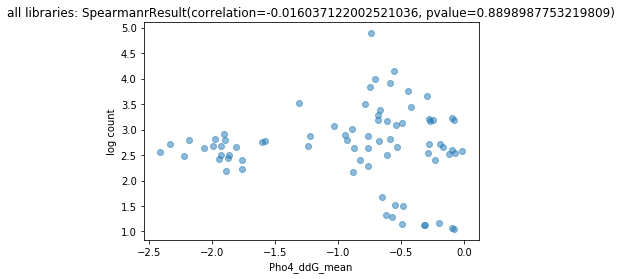

In [8]:
seqs = []
combined_tasks = ["Pho4_ddG_mean"]
for flank in lib2_good_flank_seqs+lib2_bad_flank_seqs+lib1_flank_seqs:
    seqs.append(fill_into_center(background, flank))
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
for idx, task in enumerate(lib1_task_names):
    if task not in combined_tasks: continue
    x = lib2_good_tasks[idx]+lib2_bad_tasks[idx]+lib1_tasks[idx]
    plt.scatter(x, preds, alpha=0.5)
    plt.xlabel(task)
    plt.ylabel("log count")
    plt.title("all libraries: "+str(spearmanr(x, preds)))
    plt.show()

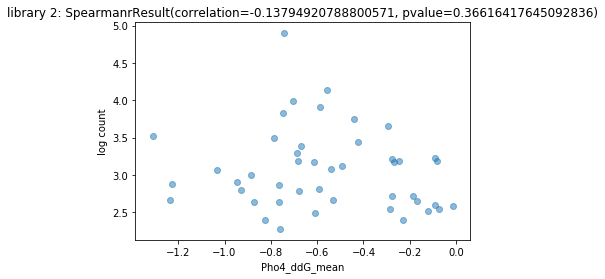

In [9]:
seqs = []
combined_tasks = ["Pho4_ddG_mean"]
for flank in lib2_good_flank_seqs+lib2_bad_flank_seqs:
    seqs.append(fill_into_center(background, flank))
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
for idx, task in enumerate(lib1_task_names):
    if task not in combined_tasks: continue
    x = lib2_good_tasks[idx]+lib2_bad_tasks[idx]
    plt.scatter(x, preds, alpha=0.5)
    plt.xlabel(task)
    plt.ylabel("log count")
    plt.title("library 2: "+str(spearmanr(x, preds)))
    plt.show()

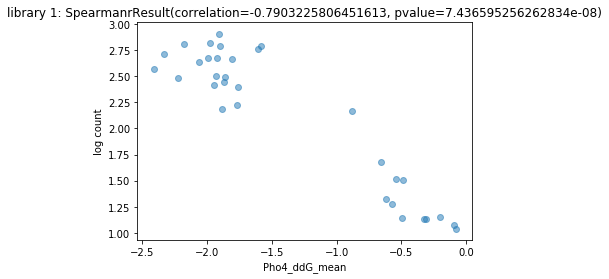

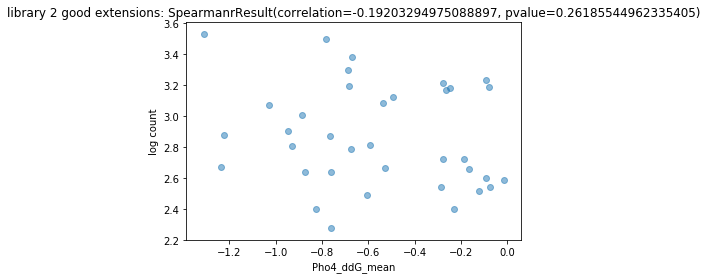

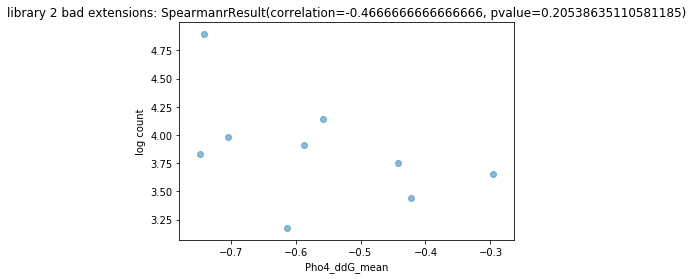

In [10]:
seqs = []
for flank in lib1_flank_seqs:
    seqs.append(fill_into_center(background, flank))
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
for idx, task in enumerate(lib1_task_names):
    plt.scatter(lib1_tasks[idx], preds, alpha=0.5)
    plt.xlabel(task)
    plt.ylabel("log count")
    plt.title("library 1: "+str(spearmanr(lib1_tasks[idx],preds)))
    plt.show()

seqs = []
for flank in lib2_good_flank_seqs:
    seqs.append(fill_into_center(background, flank))
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
for idx, task in enumerate(lib2_task_names):
    plt.scatter(lib2_good_tasks[idx], preds, alpha=0.5)
    plt.xlabel(task)
    plt.ylabel("log count")
    plt.title("library 2 good extensions: "+str(spearmanr(lib2_good_tasks[idx],preds)))
    plt.show()

seqs = []
for flank in lib2_bad_flank_seqs:
    seqs.append(fill_into_center(background, flank))
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
for idx, task in enumerate(lib2_task_names):
    plt.scatter(lib2_bad_tasks[idx], preds, alpha=0.5)
    plt.xlabel(task)
    plt.ylabel("log count")
    plt.title("library 2 bad extensions: "+str(spearmanr(lib2_bad_tasks[idx],preds)))
    plt.show()